# Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Preprocessing
df_train = pd.read_csv(r"C:\Users\ACER\Downloads\playground-series-s4e8\train.csv", index_col='id')
df_test = pd.read_csv(r"C:\Users\ACER\Downloads\playground-series-s4e8\test.csv", index_col='id')

df_train.drop(columns=['veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface'], inplace=True)
df_test.drop(columns=['veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface'], inplace=True)

In [3]:
numerical_feature = ['cap-diameter', 'stem-height', 'stem-width']
categorical_feature = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 
                      'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 
                      'has-ring', 'ring-type', 'habitat', 'season']

# Preprocessing and Data Splitting

In [4]:
# Label Encoding target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train['class'] = le.fit_transform(df_train['class'])

In [5]:
# Handle infrequent categories
def replace_infrequent_categories(df, column, threshold=70):
    value_counts = df[column].value_counts()
    infrequent = value_counts[value_counts <= threshold].index
    df[column] = df[column].apply(lambda x: "Unknown" if x in infrequent else x)
    return df

for col in categorical_feature:
    df_train = replace_infrequent_categories(df_train, col)
    df_test = replace_infrequent_categories(df_test, col)

In [6]:
def handle_skewness(df, threshold=1.0):
    numeric_cols = df.select_dtypes(include=['number']).columns
    lambda_dict = {}
    
    for col in numeric_cols:
        skewness = df[col].skew()
        if skewness > threshold:
            df[col] = df[col] + 1  # Shift data to positive
            df[col] = np.log(df[col])
            lambda_dict[col] = 'log'
    
    return df, lambda_dict

# Apply skewness handling to train and test sets
df_train, lambda_values_train = handle_skewness(df_train)
df_test, lambda_values_test = handle_skewness(df_test)


In [7]:
# Visualize skewness before and after transformation
def plot_skewness(df, title):
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(df.select_dtypes(include=['number']).columns, 1):
        plt.subplot(1, len(df.select_dtypes(include=['number']).columns), i)
        sns.histplot(df[col], kde=True)
        plt.title(f'{col} Distribution\n{title}')
    plt.tight_layout()
    plt.show()

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


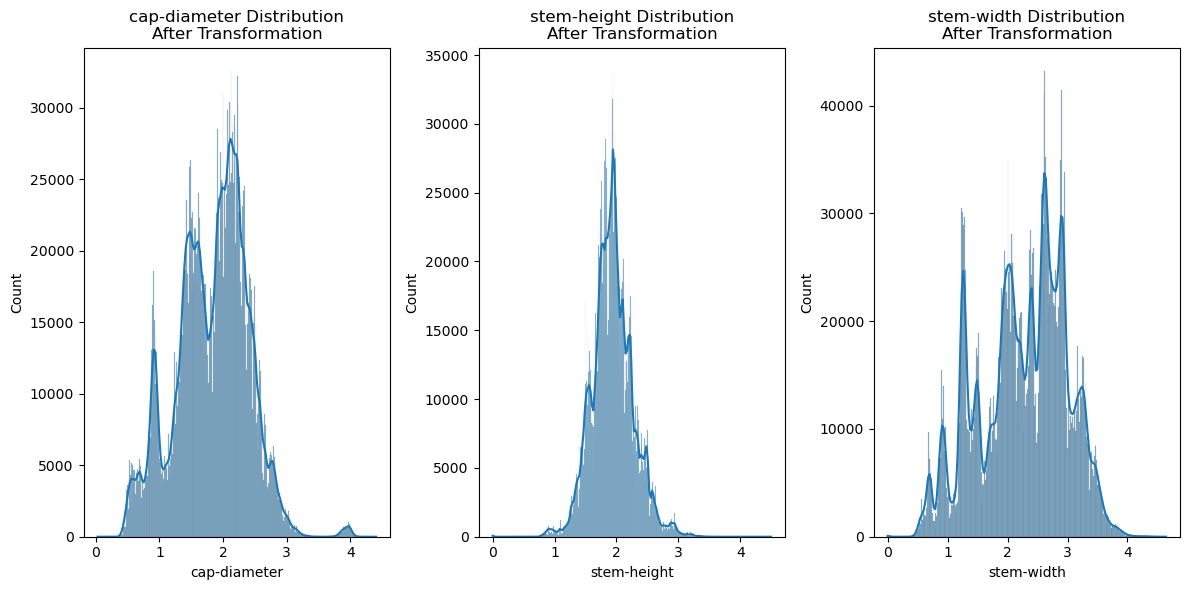

In [8]:
# After transformation
plot_skewness(df_train[numerical_feature], "After Transformation")

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


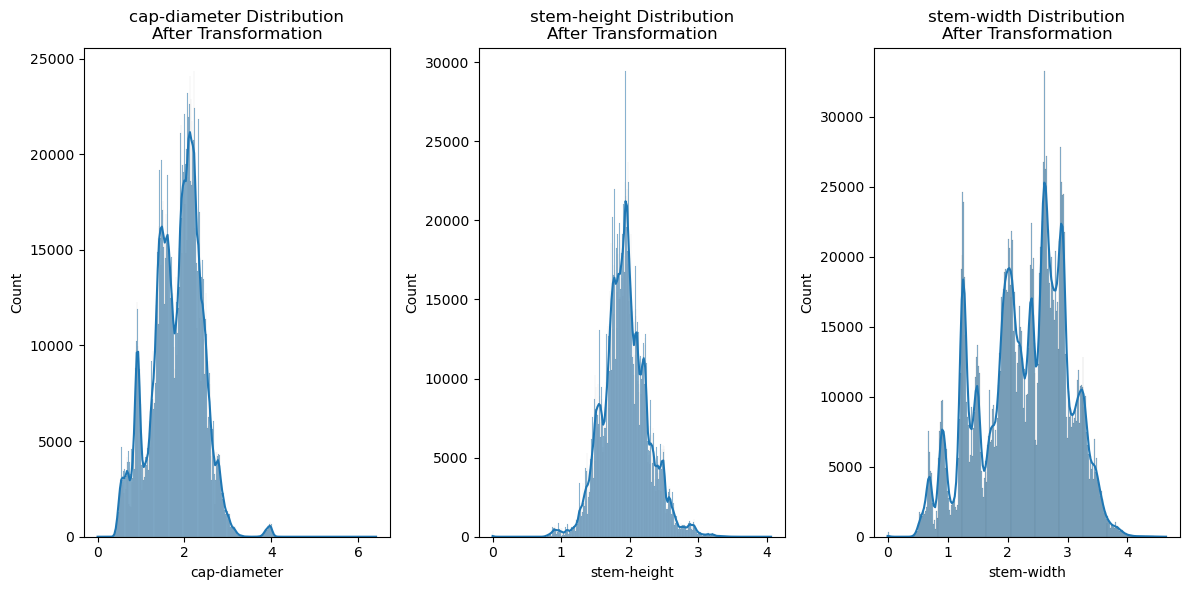

In [9]:
# After transformation
plot_skewness(df_test[numerical_feature], "After Transformation")

In [10]:
# Convert object columns to category
for col in categorical_feature:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

In [11]:
# Split data into training and testing sets
X = df_train.drop(columns='class')
y = df_train['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Define pipelines for preprocessing
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scalar', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, numerical_feature),
    ('categoric', categorical_pipeline, categorical_feature)
])

# Modelling

In [13]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# LightGBM Classifier
lgbm_model = LGBMClassifier(
    num_leaves=989,
    metric='auc',
    learning_rate=0.01150197154409214,
    feature_fraction=0.6153388926958593,
    bagging_fraction=0.830726975975083,
    bagging_freq=7,
    lambda_l1=9.285703159386265e-05,
    lambda_l2=3.5283439660576336e-08,
    max_depth=19,
    max_bin=60481,
    n_estimators=2026
)

# XGBoost Classifier
xgb_model = XGBClassifier(                    
    alpha=0,                   
    subsample=0.8,     
    colsample_bytree=0.5, 
    objective='binary:logistic',
    max_depth=20,             
    min_child_weight=10,         
    gamma=1e-6,                
    random_state=63,                 
    n_estimators=2000,   
    learning_rate=0.005
)

# Voting Classifier
estimators = [
    ('xgb', xgb_model),
    ('lgb', lgbm_model)
]

vtg_clf = VotingClassifier(estimators=estimators, voting="soft")

# Create a full pipeline with preprocessing and the voting classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', vtg_clf)
])

In [14]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6153388926958593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6153388926958593
[LightGBM] [Warning] lambda_l1 is set=9.285703159386265e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.285703159386265e-05
[LightGBM] [Warning] lambda_l2 is set=3.5283439660576336e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5283439660576336e-08
[LightGBM] [Warning] bagging_fraction is set=0.830726975975083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830726975975083
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6153388926958593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6153388926958593
[LightGBM] [Warning] lambda_l1 is set=9.285703159386265e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.285703159386265e-05
[LightGBM] [Warning

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scalar',
                                                                   MinMaxScaler())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ign...
                                                             n_estimators=2000,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)),
                                              ('lgb',
                                               LGBMClassifier(bagging_fraction=0.830726975975083,
                                                              bagging_freq=7,
                                                              feature_fraction=0.6153388926958593,
                                                              lambda_l1=9.285703159386265e-05,
                                                              lambda_l2=3.5283439660576336e-08,
                                                              learning_rate=0.01150197154409214,
                                                              max_bin=60481,
                                                              max_depth=19,
                                                              metric='auc',
                                                              n_estimators=2026,
                                                              num_leaves=989))],
                                  voting='soft'))])

# Evaluation with MCC Score

In [15]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate using F1 score and MCC score
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Print the evaluation metrics
print(f"F1 Score: {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")

[LightGBM] [Warning] feature_fraction is set=0.6153388926958593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6153388926958593
[LightGBM] [Warning] lambda_l1 is set=9.285703159386265e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.285703159386265e-05
[LightGBM] [Warning] lambda_l2 is set=3.5283439660576336e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5283439660576336e-08
[LightGBM] [Warning] bagging_fraction is set=0.830726975975083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830726975975083
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
F1 Score: 0.9926
MCC Score: 0.9837


# Apply to New Dataset and Predict

In [16]:
X_test_new = pipeline.named_steps['preprocessor'].transform(df_test)
y_test_new = pipeline.named_steps['classifier'].predict(X_test_new)

[LightGBM] [Warning] feature_fraction is set=0.6153388926958593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6153388926958593
[LightGBM] [Warning] lambda_l1 is set=9.285703159386265e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.285703159386265e-05
[LightGBM] [Warning] lambda_l2 is set=3.5283439660576336e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5283439660576336e-08
[LightGBM] [Warning] bagging_fraction is set=0.830726975975083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.830726975975083
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [17]:
y_test_new

array([0, 1, 1, ..., 1, 0, 0])

In [18]:
predictions = le.inverse_transform(y_test_new)
predictions

array(['e', 'p', 'p', ..., 'p', 'e', 'e'], dtype=object)

In [19]:
df_test['class'] = predictions
results = df_test[['class']].reset_index()
results

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e


In [20]:
results.to_csv(r"C:\Users\ACER\Downloads\Binary Prediction of Poisonous Mushrooms (Voting Classifier IV)).csv", index=False)